In [1]:
import os
import random

import pandas as pd
import numpy as np

In [2]:
SEQ_LEN=180
SPLIT=(0.6, 0.2, 0.2)

### Load data

In [3]:
data_path = 'dataset/demo/displacements/'

all_files = os.listdir(data_path)
games_inputs = {}
for filename in all_files:
    filepath = data_path + filename
    inputs = pd.read_csv(filepath)
    games_inputs[filename.split('.')[0]] = inputs

games_inputs[all_files[0].split('.')[0]].head(10)

,d_x,d_y,frames_elapsed
0,0.9875,0.0000,0.383333
1,0.0125,0.0000,0.050000
2,-0.0125,0.0000,0.166667
3,0.0125,0.0000,0.016667
4,-0.0125,0.0000,0.016667
5,-0.0125,0.0000,0.133333
6,-0.0125,0.0000,0.016667
7,-0.0375,0.3375,0.016667
8,-0.0250,0.0750,0.016667
9,-0.0250,0.0500,0.016667


### Organize by user (necessary for labelling)

In [4]:
def sort_games_by_user():
    users_sessions = {}
    for filename in all_files:
        user = filename.split('_')[0]

        if user not in users_sessions.keys():
            users_sessions[user] = []
        
        users_sessions[user].append(filename.split('.')[0])
    
    return users_sessions

games_by_player = sort_games_by_user()

inputs_by_player = {}

for player in games_by_player.keys():
    # get the inputs from all the games played by a certain player
    player_games_inputs = [games_inputs[game] for game in games_by_player[player]]
    player_inputs = pd.concat(player_games_inputs, ignore_index=True)
    
    inputs_by_player[player] = player_inputs

inputs_by_player['aklo'].shape

(128676, 3)

In [5]:
inputs_by_player.keys()

dict_keys(['axe', 'plup', 'cpu', 'kodorin', 'aklo', '2saint', 'mang0', 'n0ne', 'zain', 'hbox', 'moky', 'wizzrobe', 'sfat', 'cynthia', 'amsa', 'cody', 'logan', 'yingling'])

### Organize data into labelled sequences

In [6]:
players_set = list(inputs_by_player.keys())
players_set.sort() # ensure the mappings are the same every time

player_to_int = {key: i for i, key in enumerate(players_set)}
int_to_player = {i: key for key, i in player_to_int.items()}

def seqs_from_df(df, player_id, seq_len=100):
    seqs = []

    label = np.zeros(len(players_set))
    label[player_id] = 1.0

    for i in range(0, df.shape[0] - seq_len, int(seq_len*0.5)):
        seq_x = df.loc[i:i+seq_len-1]
        seqs.append((seq_x, label))
        
    return seqs

labelled_ml_data = [seqs_from_df(inputs_by_player[p], player_to_int[p], SEQ_LEN) for p in players_set]
labelled_ml_data = [seq for p in labelled_ml_data for seq in p] # flatten
random.shuffle(labelled_ml_data)
len(labelled_ml_data)

20957

In [7]:
int_to_player

{0: '2saint',
 1: 'aklo',
 2: 'amsa',
 3: 'axe',
 4: 'cody',
 5: 'cpu',
 6: 'cynthia',
 7: 'hbox',
 8: 'kodorin',
 9: 'logan',
 10: 'mang0',
 11: 'moky',
 12: 'n0ne',
 13: 'plup',
 14: 'sfat',
 15: 'wizzrobe',
 16: 'yingling',
 17: 'zain'}

### Split into training, validation, and test sets

In [8]:
def split_set(examples_list, split=SPLIT):
    split_indices = [0, 0, 0]
    for i in range(3):
        split_indices[i] = int(split[i] * len(examples_list))
        if i >= 1:
            split_indices[i] += split_indices[i-1]

    print(split_indices)
    
    return (examples_list[0:split_indices[0]], examples_list[split_indices[0]:split_indices[1]], examples_list[split_indices[1]:split_indices[2]])

train, valid, test = split_set(labelled_ml_data, (0.6, 0.2, 0.2))

print(f'{len(train)=}, {len(valid)=}, {len(test)=}, {len(labelled_ml_data)=}')

[12574, 16765, 20956]
len(train)=12574, len(valid)=4191, len(test)=4191, len(labelled_ml_data)=20957


In [9]:
train_x, train_y = (np.array([x.to_numpy(dtype=np.float32) for (x, _) in train], dtype=np.float32), np.array([y for (_, y) in train]))
valid_x, valid_y =(np.array([x.to_numpy(dtype=np.float32) for (x, _) in valid], dtype=np.float32), np.array([y for (_, y) in valid]))
test_x, test_y = (np.array([x.to_numpy(dtype=np.float32) for (x, _) in test], dtype=np.float32), np.array([y for (_, y) in test]))

print(f'{train_x[0]=}\n{train_x[0].shape= }, {(train_x.shape)=}\n')
print(f'\n{train_y[0]=}, {len(train_y)=}')

train_x[0]=array([[ 0.02499998, -0.325     ,  0.01666667],
       [ 0.01250005,  0.        ,  0.01666667],
       [ 0.01249999,  0.        ,  0.01666667],
       [-0.5625    ,  0.        ,  0.13333334],
       [-0.425     ,  0.        ,  0.01666667],
       [ 0.9875    ,  0.        ,  0.4       ],
       [-0.01249999,  0.        ,  0.06666667],
       [-0.11250001, -0.4875    ,  0.01666667],
       [-0.10000002, -0.13749999,  0.01666667],
       [-0.01249999, -0.02499998,  0.01666667],
       [ 0.01249999,  0.01249999,  0.05      ],
       [ 0.02500004,  0.03749996,  0.01666667],
       [ 0.02499998,  0.03750002,  0.01666667],
       [ 0.02499998,  0.03750002,  0.01666667],
       [ 0.03750002,  0.06249997,  0.01666667],
       [ 0.03750002,  0.07500002,  0.01666667],
       [ 0.03749996,  0.08749998,  0.01666667],
       [-0.95      ,  0.3       ,  0.01666667],
       [-0.45      ,  0.        ,  0.81666666],
       [-0.5125    ,  0.        ,  0.01666667],
       [-0.01250005,  0.     

### Define the model

In [10]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, ELU, Dropout, Dense, Concatenate, Flatten, GRU, LSTM

2024-05-01 10:56:50.497185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-05-01 10:56:51.913807: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 10:56:51.931030: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 10:56:51.931082: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 10:56:51.932137: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-01 10:56:51.932204: I tensorflow/compiler/xla/stream_executo

In [12]:
def createClassifier(width=3, seq_len=SEQ_LEN):
    input_layer = Input(shape=(seq_len, width))
    conv1 = Conv1D(filters=32, kernel_size=7, strides=2, activation=ELU())(input_layer)
    conv2 = Conv1D(filters=32, kernel_size=3, strides=1, activation=ELU())(input_layer)
    
    catted = Concatenate(axis=1)([conv1, conv2])
    elu1 = ELU(32)(catted)
    conv3 = Conv1D(filters=32, kernel_size=2, strides=1, activation=ELU())(elu1)
    conv4 = Conv1D(filters=32, kernel_size=2, strides=1, activation=ELU())(conv3)
    drop1 = Dropout(0.2)(conv4)

    lstm1 = LSTM(32, return_sequences=True)(drop1)
    lstm2 = LSTM(32)(lstm1)
    drop2 = Dropout(0.2)(lstm2)

    output = Dense(len(players_set), activation='softmax')(drop2)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = createClassifier(3)
model.summary()

2024-05-01 10:56:52.138508: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.139988: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.189986: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.193400: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.195906: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.197804: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.199771: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.201632: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.202175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 3)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 87, 32)               704       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 178, 32)              320       ['input_1[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 265, 32)              0         ['conv1d[0][0]',              
                                                                     'conv1d_1[0][0]']        

2024-05-01 10:56:52.473343: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.474052: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.474827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.475309: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.478819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.479416: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.479907: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.484693: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.485216: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


In [13]:
history = model.fit(
    train_x, train_y, epochs=60, verbose=1, batch_size=64, validation_data=(valid_x, valid_y)
)

Epoch 1/60


2024-05-01 10:56:52.530904: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.531991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.537221: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.538112: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.547825: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.549351: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.556489: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.557746: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52.562871: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:56:52

197/197 [==============================] - ETA: 0s - loss: 2.7379 - accuracy: 0.1298

2024-05-01 10:57:02.378354: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:02.379505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:02.380551: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:02.393664: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:02.395305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:02.407300: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:02.409373: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:02.412510: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:02.413685: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:02

197/197 [==============================] - 11s 35ms/step - loss: 2.7379 - accuracy: 0.1298 - val_loss: 2.4866 - val_accuracy: 0.1744
Epoch 2/60
197/197 [==============================] - ETA: 0s - loss: 2.5007 - accuracy: 0.1740

2024-05-01 10:57:09.589837: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:09.597973: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:09.603779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 7s 34ms/step - loss: 2.5007 - accuracy: 0.1740 - val_loss: 2.4454 - val_accuracy: 0.2128
Epoch 3/60
196/197 [============================>.] - ETA: 0s - loss: 2.3464 - accuracy: 0.2152

2024-05-01 10:57:16.388534: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:16.397017: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:16.403424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 7s 34ms/step - loss: 2.3465 - accuracy: 0.2153 - val_loss: 2.2664 - val_accuracy: 0.2493
Epoch 4/60
197/197 [==============================] - ETA: 0s - loss: 2.2901 - accuracy: 0.2352

2024-05-01 10:57:22.958795: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:22.967198: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:22.973838: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 33ms/step - loss: 2.2901 - accuracy: 0.2352 - val_loss: 2.1179 - val_accuracy: 0.2849
Epoch 5/60
196/197 [============================>.] - ETA: 0s - loss: 2.2038 - accuracy: 0.2506

2024-05-01 10:57:29.068084: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:29.071770: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:29.074624: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 2.2043 - accuracy: 0.2505 - val_loss: 2.1008 - val_accuracy: 0.3049
Epoch 6/60
196/197 [============================>.] - ETA: 0s - loss: 2.0940 - accuracy: 0.2980

2024-05-01 10:57:35.655272: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:35.662728: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:35.668378: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 7s 33ms/step - loss: 2.0931 - accuracy: 0.2982 - val_loss: 1.9350 - val_accuracy: 0.3381
Epoch 7/60
196/197 [============================>.] - ETA: 0s - loss: 1.9070 - accuracy: 0.3429

2024-05-01 10:57:42.037954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:42.041954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:42.044947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 1.9064 - accuracy: 0.3432 - val_loss: 1.7892 - val_accuracy: 0.3863
Epoch 8/60
196/197 [============================>.] - ETA: 0s - loss: 1.7937 - accuracy: 0.3758

2024-05-01 10:57:48.503918: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:48.507805: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:48.510818: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 33ms/step - loss: 1.7940 - accuracy: 0.3757 - val_loss: 1.7294 - val_accuracy: 0.4006
Epoch 9/60
197/197 [==============================] - ETA: 0s - loss: 1.7066 - accuracy: 0.4071

2024-05-01 10:57:54.704513: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:54.708380: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:57:54.711253: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 1.7066 - accuracy: 0.4071 - val_loss: 1.6164 - val_accuracy: 0.4338
Epoch 10/60
196/197 [============================>.] - ETA: 0s - loss: 1.6373 - accuracy: 0.4257

2024-05-01 10:58:00.977652: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:00.985305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:00.991154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 1.6374 - accuracy: 0.4255 - val_loss: 1.5436 - val_accuracy: 0.4593
Epoch 11/60
196/197 [============================>.] - ETA: 0s - loss: 1.7764 - accuracy: 0.3870

2024-05-01 10:58:07.278250: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:07.285857: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:07.291737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 1.7769 - accuracy: 0.3868 - val_loss: 1.6641 - val_accuracy: 0.4223
Epoch 12/60
196/197 [============================>.] - ETA: 0s - loss: 1.5784 - accuracy: 0.4479

2024-05-01 10:58:13.583444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:13.590938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:13.597202: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 1.5783 - accuracy: 0.4481 - val_loss: 1.5296 - val_accuracy: 0.4567
Epoch 13/60
196/197 [============================>.] - ETA: 0s - loss: 1.5543 - accuracy: 0.4621

2024-05-01 10:58:19.950317: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:19.957664: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:19.963451: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 1.5542 - accuracy: 0.4622 - val_loss: 1.5728 - val_accuracy: 0.4471
Epoch 14/60
196/197 [============================>.] - ETA: 0s - loss: 1.4730 - accuracy: 0.4865

2024-05-01 10:58:26.081156: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:26.088546: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:26.094287: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 1.4730 - accuracy: 0.4864 - val_loss: 1.3473 - val_accuracy: 0.5152
Epoch 15/60
197/197 [==============================] - ETA: 0s - loss: 1.4107 - accuracy: 0.5070

2024-05-01 10:58:32.296656: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:32.301120: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:32.304642: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 1.4107 - accuracy: 0.5070 - val_loss: 1.3213 - val_accuracy: 0.5283
Epoch 16/60
197/197 [==============================] - ETA: 0s - loss: 1.3546 - accuracy: 0.5242

2024-05-01 10:58:38.785623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:38.789448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:38.792450: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 7s 33ms/step - loss: 1.3546 - accuracy: 0.5242 - val_loss: 1.4830 - val_accuracy: 0.4822
Epoch 17/60
196/197 [============================>.] - ETA: 0s - loss: 1.3354 - accuracy: 0.5358

2024-05-01 10:58:45.030597: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:45.038253: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:45.044477: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 1.3359 - accuracy: 0.5356 - val_loss: 1.2632 - val_accuracy: 0.5517
Epoch 18/60
197/197 [==============================] - ETA: 0s - loss: 1.2312 - accuracy: 0.5782

2024-05-01 10:58:51.191667: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:51.199835: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:51.206337: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 1.2312 - accuracy: 0.5782 - val_loss: 1.1356 - val_accuracy: 0.6018
Epoch 19/60
196/197 [============================>.] - ETA: 0s - loss: 1.1848 - accuracy: 0.5906

2024-05-01 10:58:57.521872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:57.525726: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:58:57.528727: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 1.1853 - accuracy: 0.5905 - val_loss: 1.1420 - val_accuracy: 0.5996
Epoch 20/60
197/197 [==============================] - ETA: 0s - loss: 1.1388 - accuracy: 0.6097

2024-05-01 10:59:03.803291: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:03.810699: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:03.816395: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 33ms/step - loss: 1.1388 - accuracy: 0.6097 - val_loss: 1.0998 - val_accuracy: 0.6173
Epoch 21/60
196/197 [============================>.] - ETA: 0s - loss: 1.0914 - accuracy: 0.6243

2024-05-01 10:59:10.064872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:10.068805: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:10.071806: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 1.0917 - accuracy: 0.6242 - val_loss: 1.0158 - val_accuracy: 0.6464
Epoch 22/60
197/197 [==============================] - ETA: 0s - loss: 1.0216 - accuracy: 0.6499

2024-05-01 10:59:16.392658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:16.401210: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:16.407358: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 1.0216 - accuracy: 0.6499 - val_loss: 1.0167 - val_accuracy: 0.6531
Epoch 23/60
197/197 [==============================] - ETA: 0s - loss: 1.0057 - accuracy: 0.6601

2024-05-01 10:59:22.650152: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:22.659535: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:22.666819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 1.0057 - accuracy: 0.6601 - val_loss: 0.9312 - val_accuracy: 0.6831
Epoch 24/60
195/197 [============================>.] - ETA: 0s - loss: 0.9588 - accuracy: 0.6744

2024-05-01 10:59:28.735075: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:28.738877: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:28.741787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.9597 - accuracy: 0.6742 - val_loss: 0.9213 - val_accuracy: 0.6843
Epoch 25/60
195/197 [============================>.] - ETA: 0s - loss: 0.9109 - accuracy: 0.6927

2024-05-01 10:59:34.810956: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:34.814802: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:34.817766: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.9107 - accuracy: 0.6925 - val_loss: 0.8552 - val_accuracy: 0.7032
Epoch 26/60
197/197 [==============================] - ETA: 0s - loss: 0.8916 - accuracy: 0.7018

2024-05-01 10:59:41.099036: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:41.102881: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:41.105922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.8916 - accuracy: 0.7018 - val_loss: 0.8013 - val_accuracy: 0.7213
Epoch 27/60
195/197 [============================>.] - ETA: 0s - loss: 0.8589 - accuracy: 0.7114

2024-05-01 10:59:47.342816: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:47.351479: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:47.357450: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.8580 - accuracy: 0.7116 - val_loss: 0.9106 - val_accuracy: 0.6965
Epoch 28/60
197/197 [==============================] - ETA: 0s - loss: 0.8247 - accuracy: 0.7218

2024-05-01 10:59:53.750309: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:53.754161: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 10:59:53.757103: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.8247 - accuracy: 0.7218 - val_loss: 0.7536 - val_accuracy: 0.7437
Epoch 29/60
197/197 [==============================] - ETA: 0s - loss: 0.8059 - accuracy: 0.7309

2024-05-01 11:00:00.188780: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:00.196365: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:00.202205: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.8059 - accuracy: 0.7309 - val_loss: 0.7485 - val_accuracy: 0.7437
Epoch 30/60
195/197 [============================>.] - ETA: 0s - loss: 0.7717 - accuracy: 0.7442

2024-05-01 11:00:06.299330: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:06.303236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:06.306229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.7713 - accuracy: 0.7445 - val_loss: 0.7353 - val_accuracy: 0.7447
Epoch 31/60
197/197 [==============================] - ETA: 0s - loss: 0.7549 - accuracy: 0.7500

2024-05-01 11:00:12.599217: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:12.603002: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:12.606132: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.7549 - accuracy: 0.7500 - val_loss: 0.7216 - val_accuracy: 0.7554
Epoch 32/60
196/197 [============================>.] - ETA: 0s - loss: 0.7290 - accuracy: 0.7549

2024-05-01 11:00:18.879680: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:18.883620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:18.886553: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.7285 - accuracy: 0.7552 - val_loss: 0.7065 - val_accuracy: 0.7628
Epoch 33/60
196/197 [============================>.] - ETA: 0s - loss: 0.7117 - accuracy: 0.7652

2024-05-01 11:00:25.145183: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:25.152953: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:25.158966: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.7121 - accuracy: 0.7652 - val_loss: 0.7121 - val_accuracy: 0.7619
Epoch 34/60
196/197 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.7729

2024-05-01 11:00:31.499271: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:31.503200: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:31.506234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.6833 - accuracy: 0.7732 - val_loss: 0.6419 - val_accuracy: 0.7824
Epoch 35/60
196/197 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.7824

2024-05-01 11:00:37.542456: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:37.550282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:37.556278: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.6595 - accuracy: 0.7823 - val_loss: 0.6451 - val_accuracy: 0.7857
Epoch 36/60
196/197 [============================>.] - ETA: 0s - loss: 0.6612 - accuracy: 0.7837

2024-05-01 11:00:43.704308: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:43.711781: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:43.717567: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.6613 - accuracy: 0.7838 - val_loss: 0.6099 - val_accuracy: 0.7946
Epoch 37/60
195/197 [============================>.] - ETA: 0s - loss: 0.6192 - accuracy: 0.7966

2024-05-01 11:00:49.852621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:49.860154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:49.866019: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.6197 - accuracy: 0.7962 - val_loss: 0.6160 - val_accuracy: 0.7905
Epoch 38/60
196/197 [============================>.] - ETA: 0s - loss: 0.6152 - accuracy: 0.7970

2024-05-01 11:00:56.236638: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:56.244213: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:00:56.250253: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 33ms/step - loss: 0.6159 - accuracy: 0.7968 - val_loss: 0.6017 - val_accuracy: 0.8015
Epoch 39/60
196/197 [============================>.] - ETA: 0s - loss: 0.5910 - accuracy: 0.8080

2024-05-01 11:01:02.623773: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:02.631235: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:02.637045: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.5907 - accuracy: 0.8079 - val_loss: 0.6789 - val_accuracy: 0.7748
Epoch 40/60
196/197 [============================>.] - ETA: 0s - loss: 0.5763 - accuracy: 0.8111

2024-05-01 11:01:08.755490: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:08.759364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:08.762370: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.5765 - accuracy: 0.8110 - val_loss: 0.6704 - val_accuracy: 0.7838
Epoch 41/60
197/197 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.8103

2024-05-01 11:01:15.095876: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:15.103174: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:15.108926: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.5790 - accuracy: 0.8103 - val_loss: 0.5703 - val_accuracy: 0.8082
Epoch 42/60
195/197 [============================>.] - ETA: 0s - loss: 0.5331 - accuracy: 0.8255

2024-05-01 11:01:21.526347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:21.530372: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:21.533347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.5334 - accuracy: 0.8253 - val_loss: 0.5490 - val_accuracy: 0.8168
Epoch 43/60
196/197 [============================>.] - ETA: 0s - loss: 0.5305 - accuracy: 0.8280

2024-05-01 11:01:27.690478: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:27.697782: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:27.703427: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.5302 - accuracy: 0.8281 - val_loss: 0.5432 - val_accuracy: 0.8206
Epoch 44/60
196/197 [============================>.] - ETA: 0s - loss: 0.5230 - accuracy: 0.8290

2024-05-01 11:01:34.176044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:34.179844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:34.182803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.5228 - accuracy: 0.8289 - val_loss: 0.5782 - val_accuracy: 0.8127
Epoch 45/60
197/197 [==============================] - ETA: 0s - loss: 0.5158 - accuracy: 0.8324

2024-05-01 11:01:40.414437: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:40.422514: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:40.429618: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.5158 - accuracy: 0.8324 - val_loss: 0.5180 - val_accuracy: 0.8318
Epoch 46/60
197/197 [==============================] - ETA: 0s - loss: 0.4966 - accuracy: 0.8414

2024-05-01 11:01:46.623088: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:46.626866: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:46.629794: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.4966 - accuracy: 0.8414 - val_loss: 0.5524 - val_accuracy: 0.8184
Epoch 47/60
196/197 [============================>.] - ETA: 0s - loss: 0.4753 - accuracy: 0.8452

2024-05-01 11:01:52.810241: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:52.814160: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:52.817186: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.4754 - accuracy: 0.8452 - val_loss: 0.5491 - val_accuracy: 0.8230
Epoch 48/60
197/197 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.8433

2024-05-01 11:01:58.656430: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:58.660342: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:01:58.663352: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 30ms/step - loss: 0.4825 - accuracy: 0.8433 - val_loss: 0.6071 - val_accuracy: 0.8074
Epoch 49/60
197/197 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.8452

2024-05-01 11:02:04.796476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:04.804376: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:04.811225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.4819 - accuracy: 0.8452 - val_loss: 0.4927 - val_accuracy: 0.8366
Epoch 50/60
196/197 [============================>.] - ETA: 0s - loss: 0.4583 - accuracy: 0.8517

2024-05-01 11:02:11.141936: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:11.146141: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:11.149508: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 33ms/step - loss: 0.4586 - accuracy: 0.8515 - val_loss: 0.5166 - val_accuracy: 0.8268
Epoch 51/60
195/197 [============================>.] - ETA: 0s - loss: 0.4617 - accuracy: 0.8521

2024-05-01 11:02:17.292028: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:17.296014: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:17.299564: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.4623 - accuracy: 0.8522 - val_loss: 0.5326 - val_accuracy: 0.8151
Epoch 52/60
196/197 [============================>.] - ETA: 0s - loss: 0.4354 - accuracy: 0.8589

2024-05-01 11:02:23.530801: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:23.534659: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:23.537683: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.4351 - accuracy: 0.8588 - val_loss: 0.4461 - val_accuracy: 0.8511
Epoch 53/60
196/197 [============================>.] - ETA: 0s - loss: 0.4231 - accuracy: 0.8603

2024-05-01 11:02:29.521443: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:29.525369: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:29.528467: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.4230 - accuracy: 0.8601 - val_loss: 0.4817 - val_accuracy: 0.8342
Epoch 54/60
196/197 [============================>.] - ETA: 0s - loss: 0.4136 - accuracy: 0.8656

2024-05-01 11:02:35.596416: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:35.600412: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:35.603336: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 30ms/step - loss: 0.4136 - accuracy: 0.8655 - val_loss: 0.5302 - val_accuracy: 0.8330
Epoch 55/60
196/197 [============================>.] - ETA: 0s - loss: 0.4154 - accuracy: 0.8650

2024-05-01 11:02:41.584921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:41.592557: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:41.598359: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.4155 - accuracy: 0.8650 - val_loss: 0.5124 - val_accuracy: 0.8292
Epoch 56/60
197/197 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8642

2024-05-01 11:02:47.962951: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:47.971049: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:47.978046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.4121 - accuracy: 0.8642 - val_loss: 0.4979 - val_accuracy: 0.8335
Epoch 57/60
197/197 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8741

2024-05-01 11:02:53.954947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:53.963045: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:02:53.969484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 30ms/step - loss: 0.3956 - accuracy: 0.8741 - val_loss: 0.4325 - val_accuracy: 0.8583
Epoch 58/60
197/197 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8701

2024-05-01 11:03:00.090205: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:00.094151: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:00.097946: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 31ms/step - loss: 0.3899 - accuracy: 0.8701 - val_loss: 0.4679 - val_accuracy: 0.8411
Epoch 59/60
197/197 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8735

2024-05-01 11:03:06.457066: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:06.464559: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:06.470369: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 32ms/step - loss: 0.3943 - accuracy: 0.8735 - val_loss: 0.4305 - val_accuracy: 0.8599
Epoch 60/60
197/197 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8778

2024-05-01 11:03:12.924796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:12.932408: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:12.938213: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


197/197 [==============================] - 6s 33ms/step - loss: 0.3784 - accuracy: 0.8778 - val_loss: 0.4413 - val_accuracy: 0.8542


In [14]:
import matplotlib.pyplot as plt

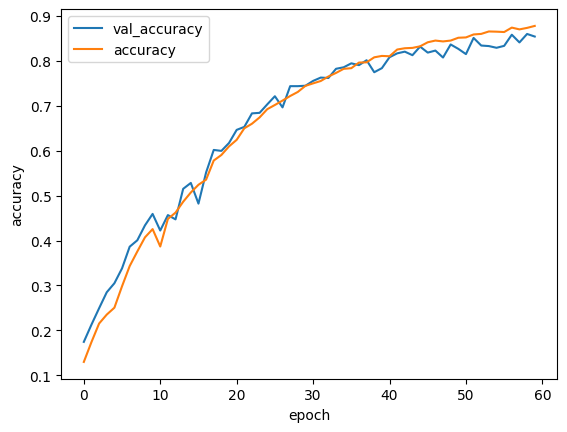

In [15]:
plt.plot('val_accuracy', data=history.history)
plt.plot('accuracy', data=history.history)
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()

# plt.savefig('results/learning_curve')
plt.show()

## Example prediction

In [29]:
example_df = pd.read_csv('dataset/demo/displacements/cynthia_cpu_20240501T093121.csv', index_col=None)
predict = model(np.array([example_df.iloc[range(SEQ_LEN), :]], dtype=np.float32), training=False)

int_to_player[np.argmax(predict)]

'cynthia'

In [27]:
np.argmax(predict)

15

In [17]:
model.save_weights('models/demo')

2024-05-01 11:03:14.123796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:14.124448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:14.124928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:14.125475: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:14.126011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:14.126876: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:14.127435: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:14.127948: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:14.128605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:03:14

## Test the model

### Get test outputs

In [24]:
test_h = []
test_h = model.predict(test_x)

test_h.shape

  3/131 [..............................] - ETA: 5s

2024-05-01 11:27:26.077087: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:27:26.089547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:27:26.124430: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:27:26.129596: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:27:26.133413: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-01 11:27:26.135840: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


131/131 [==============================] - 4s 33ms/step


(4191, 18)

### Compare test outputs to labels

In [25]:
ranks = []

for i in range(test_h.shape[0]):
    rankings = np.argsort(test_h[i])
    rank = (len(players_set)-1) - np.where((rankings == np.argmax(test_y[i])))[0][0]
    ranks.append(rank)

topn_occurences = []
running = 0
for i in range(len(players_set)):
    topn_occurences.append(ranks.count(i) + running)
    running += ranks.count(i)

topn_acc = [t / topn_occurences[-1] for t in topn_occurences]

print(topn_acc)

[0.861608208064901, 0.9458363159150561, 0.9766165592937246, 0.9871152469577666, 0.9933190169410642, 0.9966595084705321, 0.9980911476974469, 0.9995227869243617, 0.9995227869243617, 0.9997613934621808, 0.9997613934621808, 0.9997613934621808, 0.9997613934621808, 0.9997613934621808, 1.0, 1.0, 1.0, 1.0]
